# Estimating SNR by Fitting Line Profiles

In [1]:
import pathlib

import astropy.units as u
import matplotlib.pyplot as plt
import ndcube
import numpy as np
import distributed

from astropy.modeling import CompoundModel
from astropy.modeling.models import Gaussian1D, Lorentz1D, Polynomial1D
from astropy.modeling.fitting import LMLSQFitter, TRFLSQFitter
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.wcs.utils import wcs_to_celestial_frame

from mocksipipeline.util import build_moxsi_collection, read_data_cube
from mocksipipeline.modeling import project_spectral_cube, convolve_with_response
from mocksipipeline.instrument.configuration import moxsi_cdr_spectrogram_slot

In [2]:
delta_lambda = moxsi_cdr_spectrogram_slot['spectrogram_slot_1'].spectral_plate_scale / moxsi_cdr_spectrogram_slot['spectrogram_slot_1'].spatial_plate_scale

In [3]:
def get_1d_slot_spectra(collection, orders=None, cutout=None):
    if cutout is None:
        cutout = np.s_[:,:,:]
    if orders is None:
        orders = np.arange(-12,13,1)
    slot_cutouts = {f'spectrogram_slot_{i}': collection[f'spectrogram_slot_{i}'][cutout] for i in orders}
    slot_cutouts['all_components'] = collection['all_components'][cutout]
    slot_cutouts_rebin = {k: v.rebin((1, v.data.shape[1], 1), operation=np.sum).squeeze() for k, v in slot_cutouts.items()}
    return ndcube.NDCollection(slot_cutouts_rebin)

In [4]:
def fit_spectra(slot_spec, source_location, wavelength, model, window=[-20,20]):
    """
    1. Select relevant range out of reduced spectra
    2. Reduce spectra
    3. Construct model
    4. Fit model
    5. Return fitted model
    (optional) 6. Plot fitted model
    """
    idy,idx = slot_spec.wcs.world_to_array_index(source_location, wavelength)
    idx_sl = np.s_[idy, idx+window[0]:idx+window[1]]
    spec_sl = slot_spec[idx_sl]
    x_data = spec_sl.axis_world_coords(0)[0].Ty  # assumes dispersion is aligned in HPC latitude
    y_data = u.Quantity(spec_sl.data, spec_sl.unit)
    model_init = model.copy()
    if isinstance(model_initial, CompoundModel):
        for m in model_initial:
            m.amplitude = y_data[abs(window[0])]
    else:
        model_init.amplitude = y_data[abs(window[0])]
    bg = Polynomial1D(1,)
    model_init = model_init + bg
    fitter = TRFLSQFitter(calc_uncertainties=True)
    model_fit = fitter(model_init, x_data, y_data)
    return x_data, y_data, model_fit

In [5]:
selected_transitions = {
    'Ne 10': 12.1321*u.AA,
    'Fe 17': 15.0129*u.AA,
    'O 7': 21.601*u.AA,
    'Si 12': 44.160*u.AA,
}

1. Read in composite spectra from CSR forward model
2. Find source location using 0th order contribution
3. Fit zeroth order contribution to approximate source width
4. Isolate section of spectra corresponding to our four relevant lines in first order
5. Attempt to fit Gaussians to each of these

As needed, we can model the first order AR spectra with increasing exposure time to increase SNR

In [6]:
results_dir = pathlib.Path('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/rfa')

In [7]:
coronal_ar = build_moxsi_collection(results_dir / 'ar_1h_coronal' / 'detector_images', all_components_sum=False)

In [8]:
photospheric_ar = build_moxsi_collection(results_dir / 'ar_1h_photospheric_dem_coronal' / 'detector_images', all_components_sum=False)

In [9]:
idy_source, idx_source = np.unravel_index(coronal_ar['spectrogram_slot_0'][0,...].data.argmax(),
                                          coronal_ar['spectrogram_slot_0'][0,...].data.shape)
source_location = coronal_ar['spectrogram_slot_0'][0].wcs.array_index_to_world(idy_source, idx_source)

In [10]:
cutout_slice = np.s_[:,220:320,:]

In [11]:
coronal_1d_slot = get_1d_slot_spectra(coronal_ar, orders=[0,1], cutout=cutout_slice)
photospheric_1d_slot = get_1d_slot_spectra(photospheric_ar, orders=[0,1], cutout=cutout_slice)

<WCSAxes: ylabel='Data [DN]'>

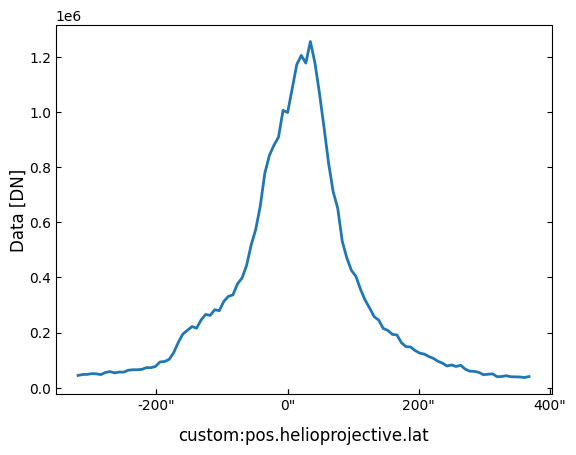

In [12]:
source_sl = coronal_1d_slot['spectrogram_slot_0'][idy_source, idx_source-50:idx_source+50]
fig = plt.figure()
ax = fig.add_subplot(projection=source_sl.wcs)
source_sl.plot(axes=ax)
#ax.axvline(x=idx_source, color='k', ls=':')

In [13]:
x_data = source_sl.axis_world_coords(0)[0].Ty
y_data = u.Quantity(source_sl.data, source_sl.unit)

In [14]:
model_0_init = Lorentz1D(amplitude=y_data[50], x_0=x_data[50], fwhm=50*u.arcsec)

In [15]:
fitter = LMLSQFitter()
model_0_fit = fitter(model_0_init, x_data, y_data)

In [16]:
x_smooth = np.linspace(*x_data[[0,-1]],1000)

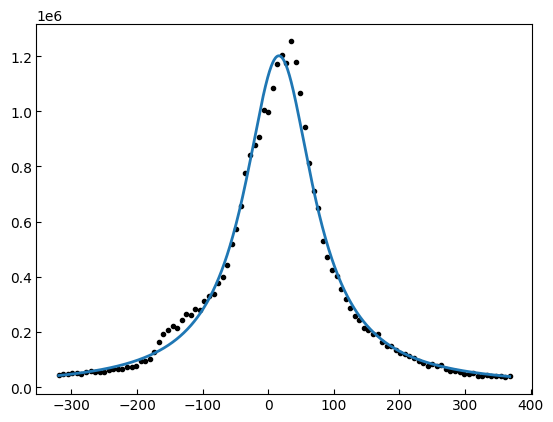

In [17]:
plt.plot(x_data, y_data, color='k', marker='.', ls='')
plt.plot(x_smooth, model_0_fit(x_smooth))

In [18]:
model_initial = Lorentz1D(x_0=model_0_fit.x_0, fwhm=model_0_fit.fwhm/3) #+ Lorentz1D(x_0=model_0_fit.x_0, fwhm=model_0_fit.fwhm/3)
#model_initial = Gaussian1D(mean=model_0_fit.x_0, stddev=model_0_fit.fwhm*gaussian_fwhm_to_sigma/4)

2024-10-29 10:49:33 - synthesizAR - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


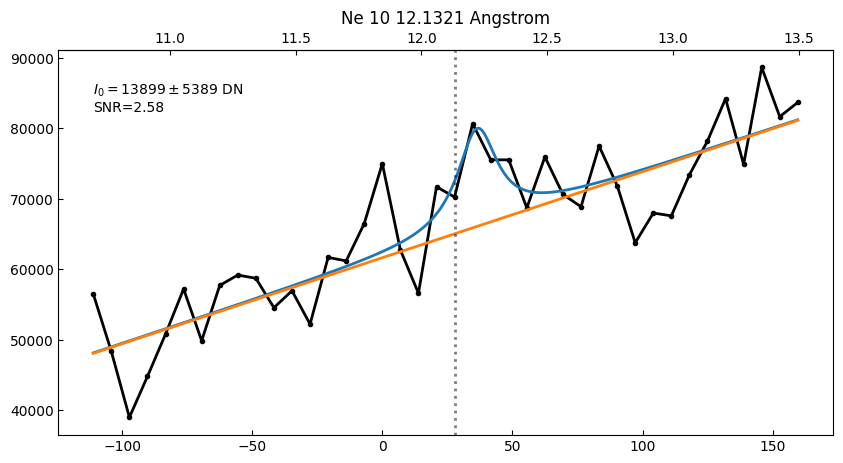

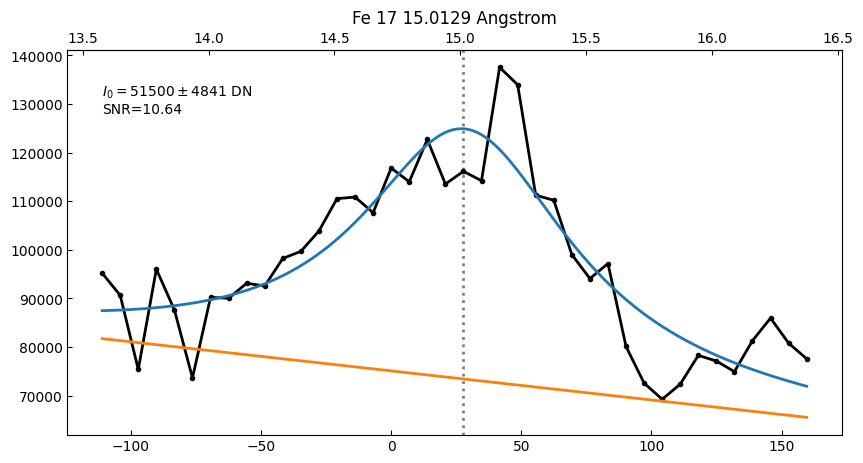

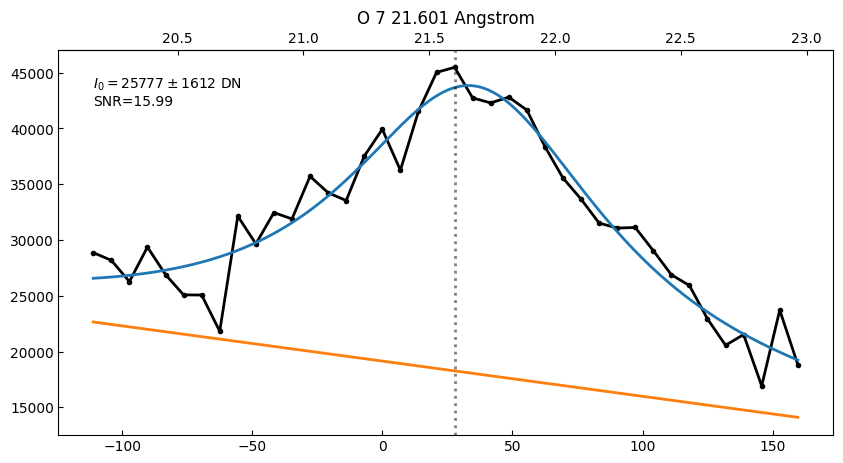

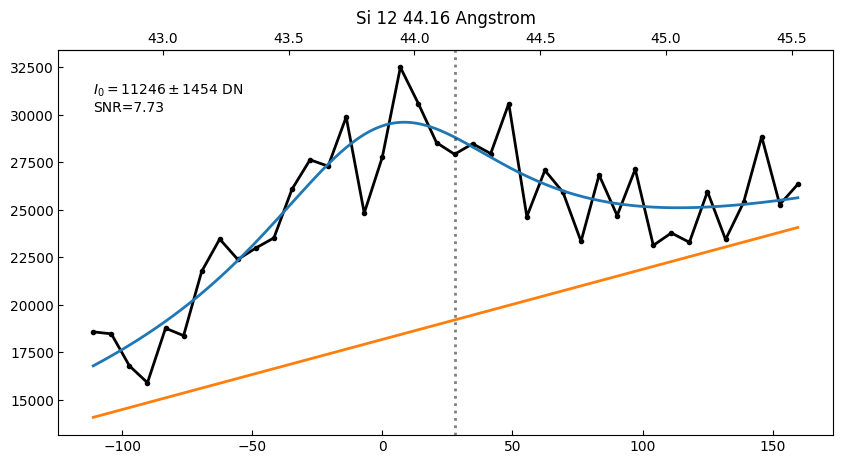

In [19]:
for i,(k,v) in enumerate(selected_transitions.items()):
    x_data, y_data, model_fit = fit_spectra(coronal_1d_slot['spectrogram_slot_1'],
                                            source_location,
                                            v,
                                            model_initial,
                                            window=[-20,20])
    intensity_uncert = np.sqrt(model_fit.cov_matrix.cov_matrix[0,0])
    x_smooth = np.linspace(*x_data[[0,-1]], 1000)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()
    ax.plot(x_data, y_data, color='k', ls='-', marker='.')
    ax.plot(x_smooth, model_fit(x_smooth))
    ax.plot(x_smooth, model_fit[-1](x_smooth))
    ax.axvline(x=source_location.Ty.value, color='k', ls=':', alpha=0.5)
    snr = model_fit.amplitude_0.value / intensity_uncert
    intensity_str = f'$I_0={model_fit.amplitude_0.value:.0f}\pm{intensity_uncert:.0f}$ {model_fit.amplitude_0.unit}'
    intensity_str += '\n' + f'SNR={snr:.2f}'
    ax.text(x_data[0].value,
                 ax.get_ylim()[-1]*0.95,
                 intensity_str,
                 va='top',
                 ha='left')
    ax.set_title(f'{k} {v}')
    ax_top = ax.secondary_xaxis(
        'top',
        functions=(lambda x: (x - source_location.Ty.value)*delta_lambda.value[1]+v.value,
                   lambda x: (x - v.value)/delta_lambda.value[1] + source_location.Ty.value)
    )
    plt.show()

In [20]:
channel = moxsi_cdr_spectrogram_slot['spectrogram_slot_1']

In [21]:
spec_cube = read_data_cube(results_dir / 'ar_1h_coronal' / 'spectral_cube.fits')

In [22]:
instr_cube = convolve_with_response(spec_cube, channel)

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/astropy/units/equivalencies.py:141: RuntimeWarning: divide by zero encountered in divide
  (si.m, si.J, lambda x: hc / x),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+'_f1']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:255: UserWarning: Readi

In [23]:
client = distributed.Client()

In [24]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57502,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:57519,Total threads: 2
Dashboard: http://127.0.0.1:57522/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:57505,


In [25]:
#integration_time = 3 * u.h
pointing_jitter = 30 * u.arcsec
observer = wcs_to_celestial_frame(spec_cube.wcs).observer

In [26]:
det_cube = project_spectral_cube(instr_cube,
                                 channel,
                                 observer,
                                 exposure=1*u.h,
                                 integration=1*u.h,
                                 pointing_jitter=pointing_jitter,
                                 include_psf=True,
                                 include_charge_spreading=False,
                                 apply_gain_conversion=False,
                                 apply_electron_conversion=False,)

coronal_1h_ar_1d_slot = det_cube[cutout_slice].rebin(
    (1, det_cube[cutout_slice].data.shape[1], 1),
    operation=np.sum
).squeeze()

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 126.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 2.37 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-10-29 10:50:50 - synthesizAR - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58313.625077 from DATE-OBS'.
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
2024-10-29 10:50:50 - synthesizAR - WARNING: FITSFixedWarning: 'unitfix' made the change 'Changed units:
  'angstrom' -> 'Angstrom'.
2024-10-29 10:50:50 - synthesizAR - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


2024-10-29 10:52:01 - synthesizAR - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


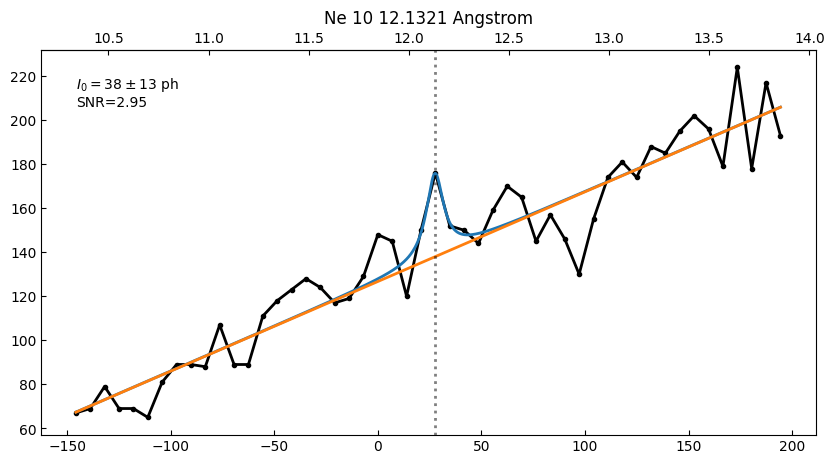

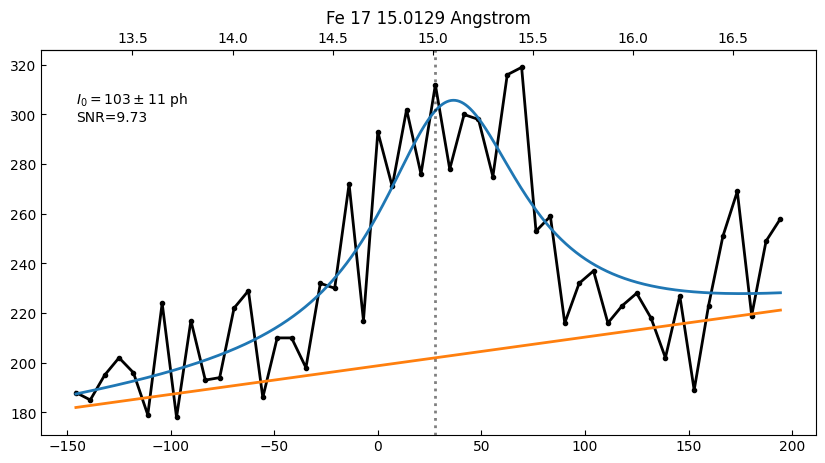

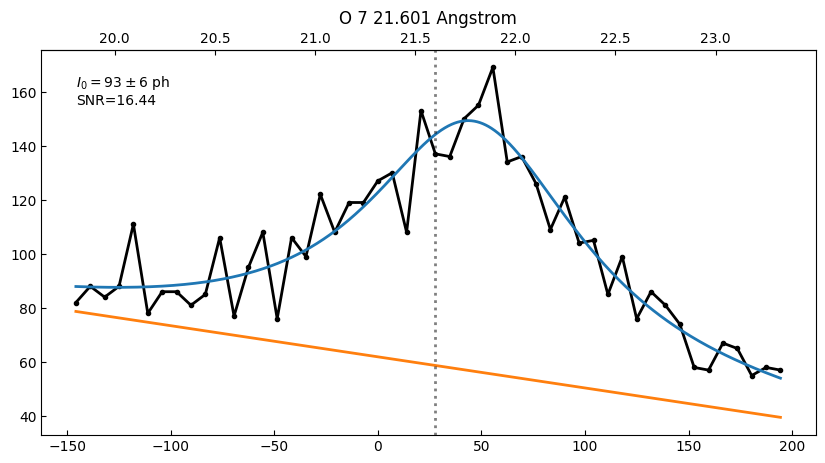

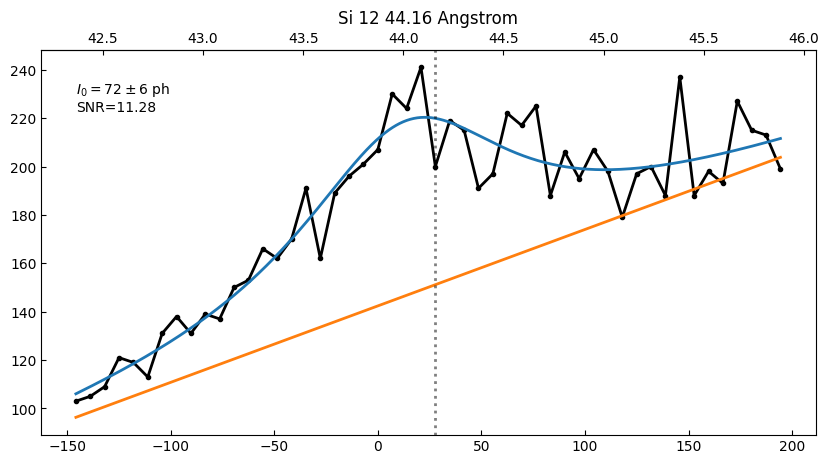

In [27]:
for i,(k,v) in enumerate(selected_transitions.items()):
    x_data, y_data, model_fit = fit_spectra(coronal_1h_ar_1d_slot,
                                            source_location,
                                            v,
                                            model_initial,
                                            window=[-25,25])
    intensity_uncert = np.sqrt(model_fit.cov_matrix.cov_matrix[0,0])
    x_smooth = np.linspace(*x_data[[0,-1]], 1000)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()
    ax.plot(x_data, y_data, color='k', ls='-', marker='.')
    ax.plot(x_smooth, model_fit(x_smooth))
    ax.plot(x_smooth, model_fit[-1](x_smooth))
    ax.axvline(x=source_location.Ty.value, color='k', ls=':', alpha=0.5)
    snr = model_fit.amplitude_0.value / intensity_uncert
    intensity_str = f'$I_0={model_fit.amplitude_0.value:.0f}\pm{intensity_uncert:.0f}$ {model_fit.amplitude_0.unit}'
    intensity_str += '\n' + f'SNR={snr:.2f}'
    ax.text(x_data[0].value,
                 ax.get_ylim()[-1]*0.95,
                 intensity_str,
                 va='top',
                 ha='left')
    ax.set_title(f'{k} {v}')
    ax_top = ax.secondary_xaxis(
        'top',
        functions=(lambda x: (x - source_location.Ty.value)*delta_lambda.value[1]+v.value,
                   lambda x: (x - v.value)/delta_lambda.value[1] + source_location.Ty.value)
    )
    plt.show()

In [28]:
det_cube = project_spectral_cube(instr_cube,
                                 channel,
                                 observer,
                                 exposure=2*u.h,
                                 integration=2*u.h,
                                 pointing_jitter=pointing_jitter,
                                 include_psf=True,
                                 include_charge_spreading=False,
                                 apply_gain_conversion=False,
                                 apply_electron_conversion=False,)

coronal_2h_ar_1d_slot = det_cube[cutout_slice].rebin(
    (1, det_cube[cutout_slice].data.shape[1], 1),
    operation=np.sum
).squeeze()

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 126.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 2.37 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-10-29 10:52:42 - synthesizAR - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58313.625077 from DATE-OBS'.
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
2024-10-29 10:52:42 - synthesizAR - WARNING: FITSFixedWarning: 'unitfix' made the change 'Changed units:
  'angstrom' -> 'Angstrom'.
2024-10-29 10:52:43 - synthesizAR - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


2024-10-29 10:54:54 - synthesizAR - WARNING: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change


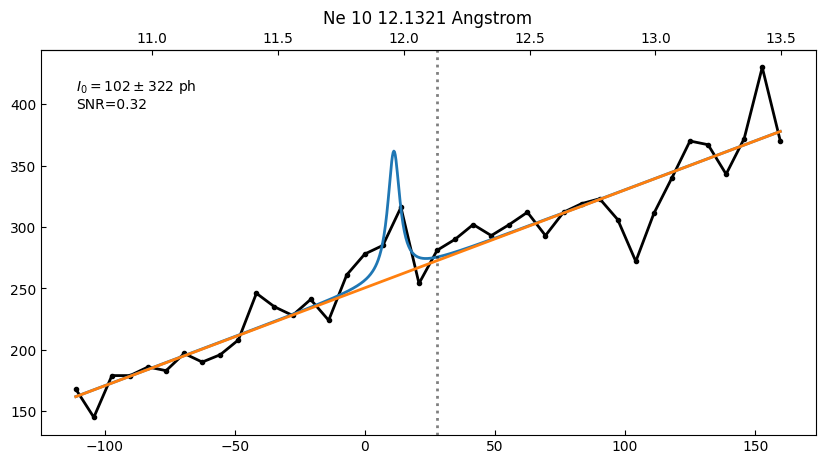

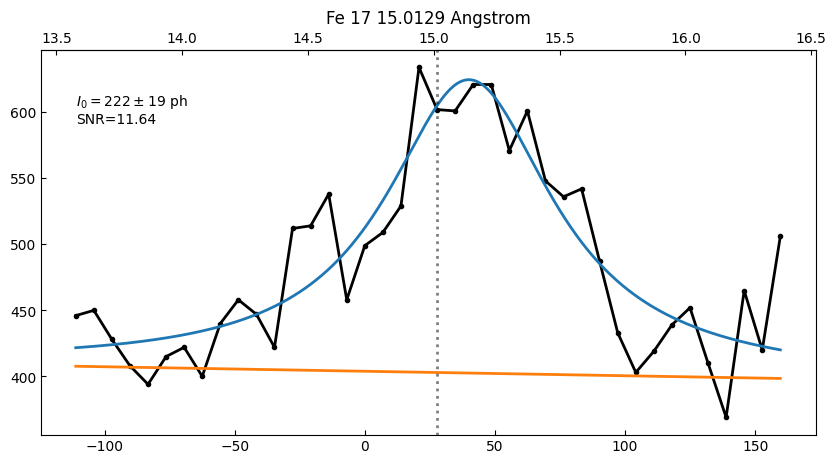

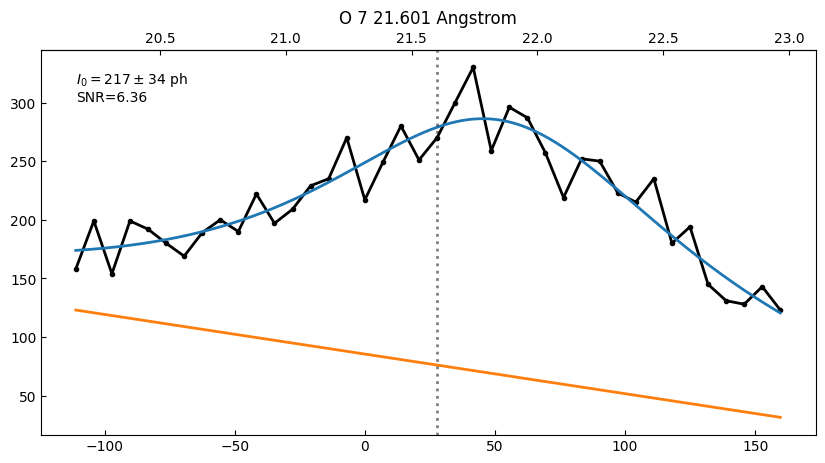

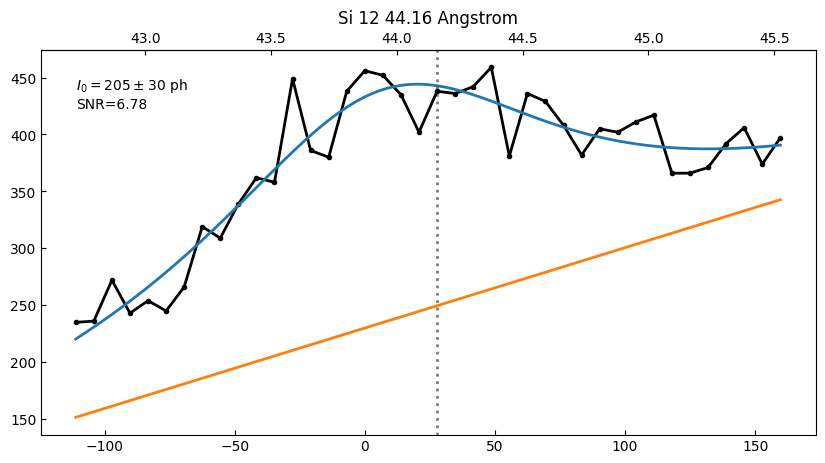

2024-10-29 13:45:35,404 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 7 memory: 14224 MB fds: 311>>
Traceback (most recent call last):
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/psutil/__init__.py", line 2122, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory
2024-10-29 14:56:12,386 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: 

In [29]:
for i,(k,v) in enumerate(selected_transitions.items()):
    x_data, y_data, model_fit = fit_spectra(coronal_2h_ar_1d_slot,
                                            source_location,
                                            v,
                                            model_initial,
                                            window=[-20,20])
    intensity_uncert = np.sqrt(model_fit.cov_matrix.cov_matrix[0,0])
    x_smooth = np.linspace(*x_data[[0,-1]], 1000)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()
    ax.plot(x_data, y_data, color='k', ls='-', marker='.')
    ax.plot(x_smooth, model_fit(x_smooth))
    ax.plot(x_smooth, model_fit[-1](x_smooth))
    ax.axvline(x=source_location.Ty.value, color='k', ls=':', alpha=0.5)
    snr = model_fit.amplitude_0.value / intensity_uncert
    intensity_str = f'$I_0={model_fit.amplitude_0.value:.0f}\pm{intensity_uncert:.0f}$ {model_fit.amplitude_0.unit}'
    intensity_str += '\n' + f'SNR={snr:.2f}'
    ax.text(x_data[0].value,
                 ax.get_ylim()[-1]*0.95,
                 intensity_str,
                 va='top',
                 ha='left')
    ax.set_title(f'{k} {v}')
    ax_top = ax.secondary_xaxis(
        'top',
        functions=(lambda x: (x - source_location.Ty.value)*delta_lambda.value[1]+v.value,
                   lambda x: (x - v.value)/delta_lambda.value[1] + source_location.Ty.value)
    )
    plt.show()